## Appendix

In [0]:
# Authentication and Setup 
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Ncessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 100)

import os
import imageio # used for writing images
from random import shuffle
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers. normalization import BatchNormalization
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.simplefilter("ignore")

In [3]:
# Mounting google drive; link google drive with colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Changing the driectory to the train images folder
os.chdir("/content/drive/My Drive/labeled_train")

In [0]:
# Reading in the Excel and create a dictionary
# Key is image_id and value is label

cat_dict = {} # id: label
f = open("Chest_xray_Corona_Metadata.csv", "r")
cont = f.read()
cont = cont.split('\n')
for i in range(1,len(cont)-1):
    cont[i] = cont[i].split(',')
    cat_dict[cont[i][1]] = cont[i][2]

In [0]:
# Keep a count of the labels
category = cat_dict.values()
cat_set = set(category)
label_count = {}
for i in cat_set:
    label_count[i] = 0

In [0]:
# Read in the image from the train directory and store it in another directory labeled_train with name as label_count.png
# Example IMG_001.Jpeg will be stored as Normal_1.png
# Do not run on Colab
for img in os.listdir('./Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'):
    if cat_dict.get(img):
        label_count[cat_dict.get(img)] += 1
        path = os.path.join('./Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train', img)
        saveName = './labeled_train/' + cat_dict.get(img) + '-' + str(label_count[cat_dict.get(img)]) + '.png'
        image_data = np.array(Image.open(path))
        imageio.imwrite(saveName, image_data)

# Doing the same thing for test images 
for img in os.listdir('./Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'):
    if cat_dict.get(img):
        label_count[cat_dict.get(img)] += 1
        path = os.path.join('./Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test', img)
        saveName = './labeled_test/' + cat_dict.get(img) + '-' + str(label_count[cat_dict.get(img)]) + '.png'
        image_data = np.array(Image.open(path))
        imageio.imwrite(saveName, image_data)

In [29]:
# Basic statistics about the train images
DIR = '/content/drive/My Drive/labeled_train'
def get_size_statistics():
    heights = []
    widths = []
    img_count = 0
    for img in os.listdir(DIR):
        path = os.path.join(DIR, img)
        data = np.array(Image.open(path))
        heights.append(data.shape[0])
        widths.append(data.shape[1])
        img_count += 1
    avg_height = sum(heights) / len(heights)
    avg_width = sum(widths) / len(widths)
    print("Average Height: " + str(avg_height))
    print("Max Height: " + str(max(heights)))
    print("Min Height: " + str(min(heights)))
    print('\n')
    print("Average Width: " + str(avg_width))
    print("Max Width: " + str(max(widths)))
    print("Min Width: " + str(min(widths)))

get_size_statistics()

Average Height: 971.4003780718336
Max Height: 3480
Min Height: 127


Average Width: 1321.391304347826
Max Width: 4248
Min Width: 255


In [0]:
# Assigning the labels as Normal:1 Pneumoinia: 0
def label_img(name):
    word_label = name.split('-')[0]
    if word_label == 'Normal': return np.array(1)
    elif word_label == 'Pnemonia' : return np.array(0)


In [0]:
# Library where the training images are stored on google drive
DIR = '/content/drive/My Drive/labeled_train'

# Setting the image size to be 300
IMG_SIZE = 300

# Function to load in the training data with image array and corresponding labels
def load_training_data():
    train_data = []
    for img in os.listdir():
        label = label_img(img)
        path = os.path.join(DIR, img)
        img = Image.open(img)
        img = img.convert('L')
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        train_data.append([np.array(img), label])
        
    shuffle(train_data)
    return train_data

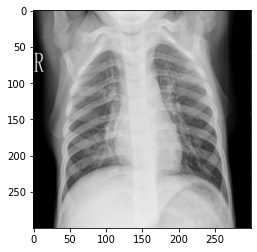

In [7]:
# Loading the train data and see an example
train_data = load_training_data()
plt.imshow(train_data[43][0], cmap = 'gist_gray')

In [8]:
# Splitting the train data into fetaures and labels and doing the necessary reshaping
trainImages = np.array([i[0] for i in train_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
trainLabels = np.array([i[1] for i in train_data])

print("Shape of train images is:", trainImages.shape)
print("Shape of labels is:", trainLabels.shape)


Shape of train images is: (5290, 300, 300, 1)
Shape of labels is: (5290,)


Text(0.5, 1.0, 'Pneumonia (1) and Normal (0) count in training')

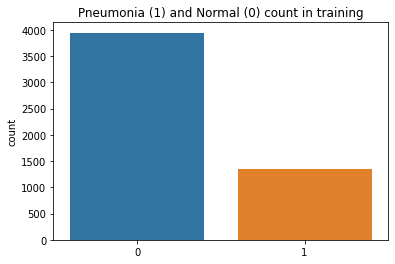

In [26]:
# Distribution of the training labels
sns.countplot(trainLabels)
plt.title("Pneumonia (1) and Normal (0) count in training")

In [9]:
#Lets split the data into train and test set
X_train, X_val, y_train, y_val = train_test_split(trainImages, trainLabels, test_size=0.20, random_state=2)

print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_val.shape)

Shape of train images is: (4232, 300, 300, 1)
Shape of validation images is: (1058, 300, 300, 1)
Shape of labels is: (4232,)
Shape of labels is: (1058,)


In [0]:
# Network Architecture 
batch_size = 32
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(300, 300, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))  #Dropout for regularization
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  #Sigmoid function at the end because we have just two classes

In [12]:
# Summary of the Network
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 33, 128)      

In [0]:
# Compiling the model
model.compile(loss='binary_crossentropy', optimizer=optimizers.adam(lr=1e-4), metrics = ['accuracy'])

In [0]:
# Setting up the Image Data Generator for Data Augmentation
# Included re-scaling, rotation, zooming and flipping of images
train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,)

# Validation images only need to be re-scaled
val_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
# Instantiating the generator objects
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [ ]:
# Build the model; Run for 60 epochs, this number came by trial and error
ntrain = len(X_train)
nval = len(X_val)
history = model.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=60,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size)

In [0]:
# Loading in the Test data

# Setting the directory to point to where the test images are stored on Google drive
DIR = '/content/drive/My Drive/labeled_test'
#Keeping the image size consistent 
IMG_SIZE = 300
def load_test_data():
    test_data = []
    for img in os.listdir(DIR):
        label = label_img(img)
        path = os.path.join(DIR, img)
        img = Image.open(path)
        img = img.convert('L')
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        test_data.append([np.array(img), label])
        
    shuffle(test_data)
    return test_data

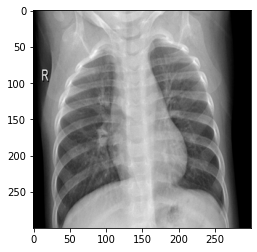

In [133]:
# Save the test images and see one of them
test_data = load_test_data()
plt.imshow(test_data[43][0], cmap = 'gist_gray')

In [0]:
# Split into images and labels and reshape just like train data
testImages = np.array([i[0] for i in test_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
testLabels = np.array([i[1] for i in test_data])

# Only  rescaling of the features is requires
testImages = testImages.astype('float32') / 255

In [135]:
# Checking the accuracy of the model
test_loss, test_acc = model.evaluate(testImages, testLabels)
print(f"The Accuracy on the test set is: {test_acc}")

624/624 [==============================] - 1s 2ms/step
The Accuracy on the test set is: 0.9054487347602844


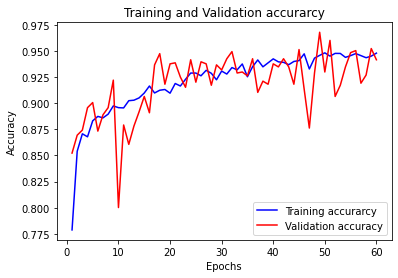

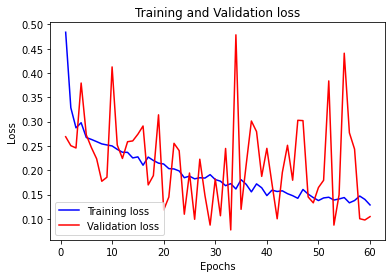

In [27]:
#get the details form the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [0]:
# Visulalise Test data
testImages_vis = np.array([i[0] for i in test_data[0:10]]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
testLabels_vis = np.array([i[1] for i in test_data[0:10]])
x = np.array(testImages_vis)
test_datagen = ImageDataGenerator(rescale=1./255)



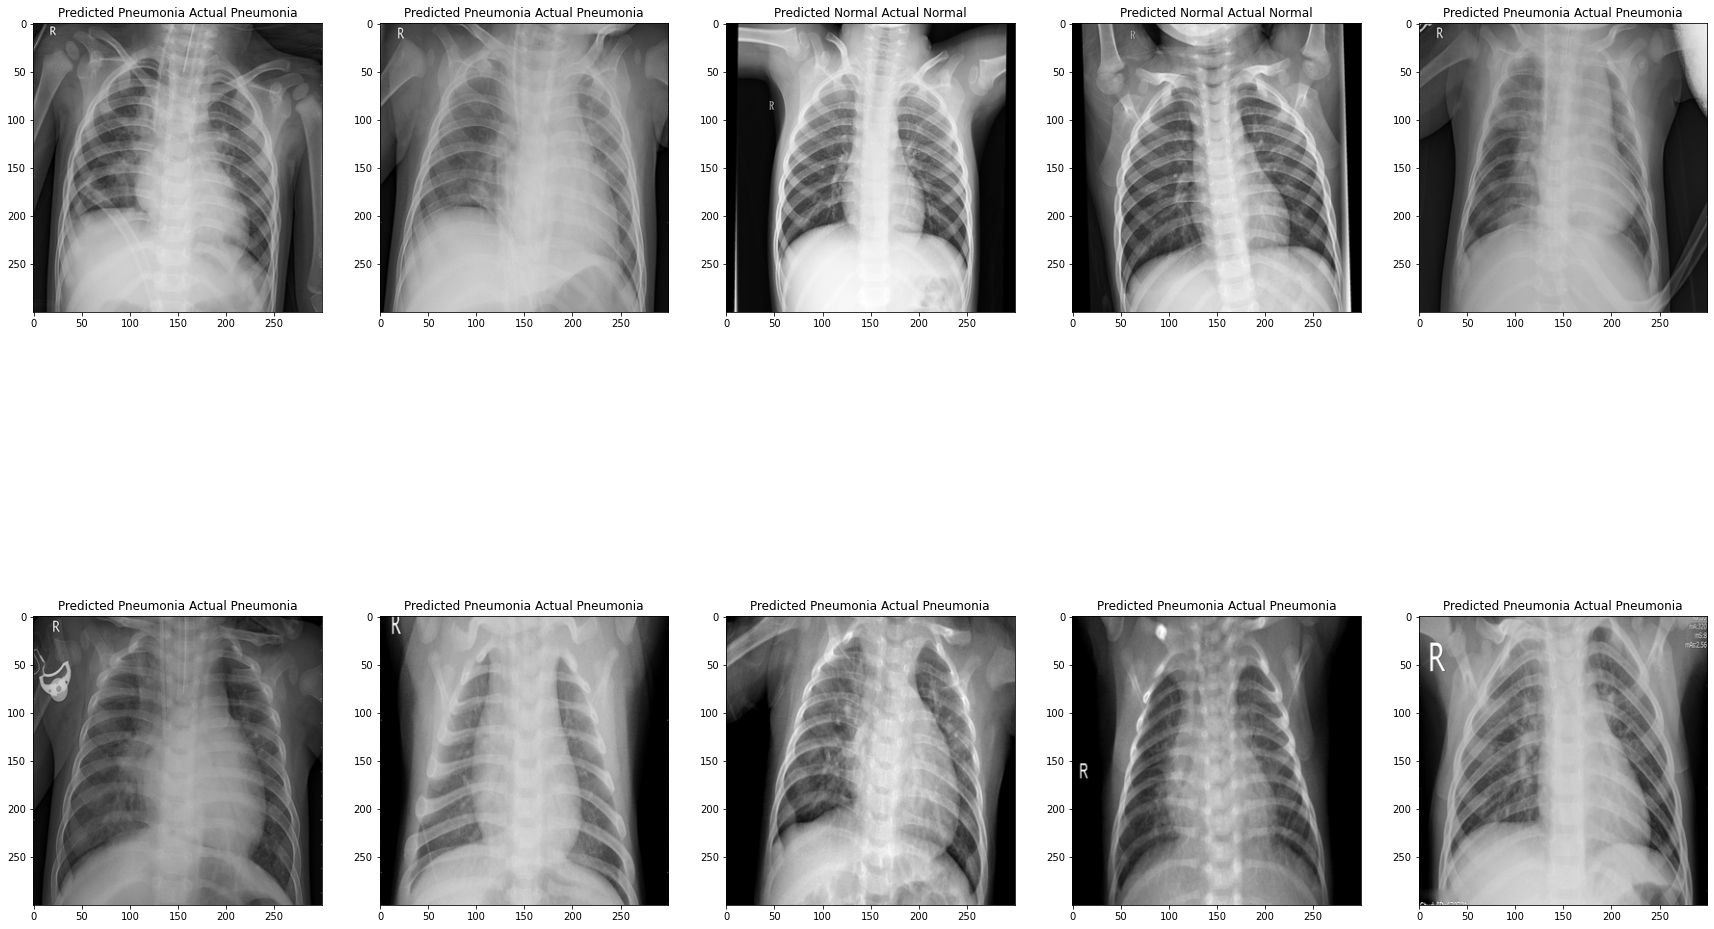

In [138]:
i = 0
text_labels = []
plt.figure(figsize=(30,20))
columns = 5
for batch in test_datagen.flow(x, testLabels_vis, batch_size=1):
    pred = model.predict(batch[0])
    if pred > 0.5:
        text_labels.append('Normal')
    else:
        text_labels.append('Pneumonia')
    plt.subplot(5 / columns + 1, columns, i + 1)
    if np.count_nonzero(batch[1]) != 0:
      tit = 'Predicted ' + str(text_labels[i]) + ' Actual Normal'
    else:
      tit = 'Predicted ' + str(text_labels[i]) + ' Actual Pneumonia'

    plt.title(tit)
    imgplot = plt.imshow(batch[0][0][:,:,0], cmap='gray')
    i += 1
    if i % 10 == 0:
        break
plt.show()